# Libraries & Custom functions

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Build a custom CNN composed of 5 convolutional layers with ReLU activation between all the five layers and a fully-connected output layer.

class FashionMNIST_ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0)
        self.conv3 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0)
        self.conv4 = torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 0)
        self.conv5 = torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 0)
        self.fc = torch.nn.Linear(512 * 7 * 7, 10)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avgpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(-1, 512 * 7 * 7)
        x = self.fc(x)
        return x
    

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = [], [], [], []

    # Create a plot with labeled axes
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        val_loss /= len(test_loader)
        val_accuracy = 100 * correct / total
        print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
        print(f'Validation Accuracy = {val_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        test_loss_hist.append(val_loss)
        test_acc_hist.append(val_accuracy)


    # Plot the training loss over epochs
    epochs = range(2, len(train_loss_hist) + 1)

    plt.plot(epochs, train_loss_hist[1:], label='Training Loss')
    plt.plot(epochs, test_loss_hist[1:], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Evolution')
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")
    print()
    print(f"Cross-Entropy on validation set: {test_loss_hist[-1]:.4f}")
    print(f"Accuracy on validation set:      {test_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

# Exercise 1

## Exercise 1 (A)

### Exercise 1 (A) i) - Change the padding from 0 to 1

By changing the padding from zero to one, what happens is that a convolutional layer's input size will be increased by one border, ensuring that the layer's output size will be larger as well, assuming all the remaining hyper-parameters are kept the same. 

Given an image size of 30x30xK, a padding of 1 can be implemented so that the image's intensity values in its borders get used more that once for making convolution operations, meaning that this border data is used more times than it would be with a padding of 0. This can be crucial because important data might be in the borders, and therefore by applying a padding of 1 we ensure that the data in the borders is used more times to compute the outputs of that convolutional layer. A padding of 1 will increase the size of this given image from 30x30xK to 31x31xK, where this new border will have no importance in terms of its values, however enable the data in the real borders to get used more times. 

For example, for a convolutional layer with stride of 1 and kernel size of 3, with a padding of 0 a corner will get used once and an edge either 2 (edge point next to a corner) or 3 times, while with a padding of 1 a corner data point will be used 4 times, while the edges will be used 6 times.

### Exercise 1 (A) ii) - Change the kernel size from 3 to 4

By changing the kernel size from 3 to 4, what ends up happening is that the output dimensions of the convolutional layer decrease (assuming everything else constant), while the input dimensions stay the same. 

Notice that by increasing the kernel size by one the number of convolutions applied to an image (for example) gets reduced, and because for each convolution operation one value (output value) is computed, then the number of values added to the output is decreased, meaning that the output dimensions will decrease.

### Exercise 1 (A) iii) - Change the stride from 1 to 2

By changing the stride from 1 to 2, what ends up happening is that several convolution operations get skipped in a convolutional layer, and because each convolution computes one value of the layer's output, the output's dimensions get decreased, while the input size remains the same. 

With a stride of 1, what happens is that the kernel moves one column at a time in the same row, and one row at a time in the same column. However, with a stride of 2 the kernel moves two columns at a time in the same row, and two rows at a time in the same column. In short, a convolutional layer with stride of 2 skips one convolution operations at a time, meaning that only half of the convolutions made with a stride of 1 will actually occur with stride 2.

Looking at the equation that defines the output size, by changing the stride from 1 to 2, the output dimensions get decreased practically in half because of the decay in the number of convolution operations mention above.

## Exercise 1 (B)

Looking at the following statement: ”Pooling layers introduce a trade-off between information loss and dimensionality reduction”, we can say that is summarizes correctly the role that a Pooling layer has in a convolutional neural network. 

A pooling layer shares one main idea with a convolutional layer, which is the fact that it reduces the size of the input by applying a kernel to it. However, a pooling layer is much different that a convolutional layer because of two main factors. Firstly, the kernel in a pooling layers doesn't apply convolution operation to the input; a pooling layer can apply either a maximum operation, an average operation, or a minimum operation (althouth the first two are more used given their proven performance superiority). Secondly, a pooling layer doesn't have any trainable parameters (or parameters even), while a convolutional layer has. This second difference is very crucial because we're able to simplify our problem by reducing the size of the data without increase the model's complexity (number of trainable parameters). 

Now, reduncing our data's dimensions comes with a cost... Because we're reducing the size of the data given to a pooling layer, what happens is that we lose information by filtering some data out. For example, a MaxPooling layer with a kernel size of 2 retrieves only one value from a region with four values at a time (just like in a convolutional layer), and this is applied to all the data points given to the model (images for example). Usually a pooling layer with a kernel size of 2 is also used with a stride of 2, and this means that we reduce the input data by exactly half while filtering out 75% of all the data values for each pooling operation. 

So, going back to the initial statement... It's true that we lose information by applying a pooling layer (regardless of what type), however we have the trade-off of reducing our data's dimensions, and dimensionality reduction is crucial because computational resources aren't infinite, and so we need it in order to train ConvNets more efficiently and in timely manner.

## Exercise 1 (C)

In [9]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = transform, download = True)

batch_size = 128

TrainLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
TestLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

### Exercise 1 (C) i)

In [10]:
# Initialize the network, loss function, and optimizer
device = set_device()
ConvNet = FashionMNIST_ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.2486  |  Accuracy = 74.83% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]


Training Cross-Entropy Loss = 1.3032
Training Accuracy = 74.83%
======== Validation phase ========


Loss = 0.6020  |  Accuracy = 83.71% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.58it/s]


Validation Cross-Entropy Loss = 0.4693
Validation Accuracy = 83.71%

Epoch 2/24
======== Training phase ========


Loss = 0.4065  |  Accuracy = 85.14% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]


Training Cross-Entropy Loss = 0.4145
Training Accuracy = 85.14%
======== Validation phase ========


Loss = 0.4524  |  Accuracy = 85.56% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.43it/s]


Validation Cross-Entropy Loss = 0.4043
Validation Accuracy = 85.56%

Epoch 3/24
======== Training phase ========


Loss = 0.4057  |  Accuracy = 87.16% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]


Training Cross-Entropy Loss = 0.3569
Training Accuracy = 87.16%
======== Validation phase ========


Loss = 0.2084  |  Accuracy = 86.70% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.91it/s]


Validation Cross-Entropy Loss = 0.3672
Validation Accuracy = 86.70%

Epoch 4/24
======== Training phase ========


Loss = 0.2584  |  Accuracy = 87.88% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


Training Cross-Entropy Loss = 0.3356
Training Accuracy = 87.88%
======== Validation phase ========


Loss = 0.3245  |  Accuracy = 87.58% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.86it/s]


Validation Cross-Entropy Loss = 0.3589
Validation Accuracy = 87.58%

Epoch 5/24
======== Training phase ========


Loss = 0.3406  |  Accuracy = 88.24% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


Training Cross-Entropy Loss = 0.3220
Training Accuracy = 88.24%
======== Validation phase ========


Loss = 0.2773  |  Accuracy = 87.93% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.64it/s]


Validation Cross-Entropy Loss = 0.3438
Validation Accuracy = 87.93%

Epoch 6/24
======== Training phase ========


Loss = 0.2917  |  Accuracy = 88.51% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]


Training Cross-Entropy Loss = 0.3160
Training Accuracy = 88.51%
======== Validation phase ========


Loss = 0.3720  |  Accuracy = 87.91% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 55.20it/s]


Validation Cross-Entropy Loss = 0.3450
Validation Accuracy = 87.91%

Epoch 7/24
======== Training phase ========


Loss = 0.3311  |  Accuracy = 88.98% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]


Training Cross-Entropy Loss = 0.3014
Training Accuracy = 88.98%
======== Validation phase ========


Loss = 0.3443  |  Accuracy = 87.84% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 74.15it/s]


Validation Cross-Entropy Loss = 0.3535
Validation Accuracy = 87.84%

Epoch 8/24
======== Training phase ========


Loss = 0.2866  |  Accuracy = 89.16% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]


Training Cross-Entropy Loss = 0.3024
Training Accuracy = 89.16%
======== Validation phase ========


Loss = 0.3958  |  Accuracy = 87.84% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 55.16it/s]


Validation Cross-Entropy Loss = 0.3557
Validation Accuracy = 87.84%

Epoch 9/24
======== Training phase ========


Loss = 0.2486  |  Accuracy = 89.06% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]


Training Cross-Entropy Loss = 0.3015
Training Accuracy = 89.06%
======== Validation phase ========


Loss = 0.1040  |  Accuracy = 88.50% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.14it/s]


Validation Cross-Entropy Loss = 0.3248
Validation Accuracy = 88.50%

Epoch 10/24
======== Training phase ========


Loss = 0.2693  |  Accuracy = 89.16% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]


Training Cross-Entropy Loss = 0.3006
Training Accuracy = 89.16%
======== Validation phase ========


Loss = 0.1658  |  Accuracy = 88.39% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.13it/s]


Validation Cross-Entropy Loss = 0.3293
Validation Accuracy = 88.39%

Epoch 11/24
======== Training phase ========


Loss = 0.2800  |  Accuracy = 89.00% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]


Training Cross-Entropy Loss = 0.3003
Training Accuracy = 89.00%
======== Validation phase ========


Loss = 0.1402  |  Accuracy = 88.41% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 71.46it/s]


Validation Cross-Entropy Loss = 0.3336
Validation Accuracy = 88.41%

Epoch 12/24
======== Training phase ========


Loss = 0.2521  |  Accuracy = 89.16% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]


Training Cross-Entropy Loss = 0.2983
Training Accuracy = 89.16%
======== Validation phase ========


Loss = 0.2850  |  Accuracy = 88.32% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 54.96it/s]


Validation Cross-Entropy Loss = 0.3300
Validation Accuracy = 88.32%

Epoch 13/24
======== Training phase ========


Loss = 0.2266  |  Accuracy = 89.41% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]


Training Cross-Entropy Loss = 0.2880
Training Accuracy = 89.41%
======== Validation phase ========


Loss = 0.3227  |  Accuracy = 88.07% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.53it/s]


Validation Cross-Entropy Loss = 0.3365
Validation Accuracy = 88.07%

Epoch 14/24
======== Training phase ========


Loss = 0.2991  |  Accuracy = 89.36% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]


Training Cross-Entropy Loss = 0.2910
Training Accuracy = 89.36%
======== Validation phase ========


Loss = 0.2139  |  Accuracy = 87.71% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 73.22it/s]


Validation Cross-Entropy Loss = 0.3554
Validation Accuracy = 87.71%

Epoch 15/24
======== Training phase ========


Loss = 0.3335  |  Accuracy = 88.41% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


Training Cross-Entropy Loss = 0.3231
Training Accuracy = 88.41%
======== Validation phase ========


Loss = 0.6536  |  Accuracy = 86.15% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 73.85it/s]


Validation Cross-Entropy Loss = 0.3978
Validation Accuracy = 86.15%

Epoch 16/24
======== Training phase ========


Loss = 0.2370  |  Accuracy = 88.40% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


Training Cross-Entropy Loss = 0.3146
Training Accuracy = 88.40%
======== Validation phase ========


Loss = 0.3221  |  Accuracy = 87.85% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 64.44it/s]


Validation Cross-Entropy Loss = 0.3603
Validation Accuracy = 87.85%

Epoch 17/24
======== Training phase ========


Loss = 0.3874  |  Accuracy = 89.61% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]


Training Cross-Entropy Loss = 0.2854
Training Accuracy = 89.61%
======== Validation phase ========


Loss = 0.5692  |  Accuracy = 87.79% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 74.16it/s]


Validation Cross-Entropy Loss = 0.3539
Validation Accuracy = 87.79%

Epoch 18/24
======== Training phase ========


Loss = 0.2774  |  Accuracy = 89.39% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]


Training Cross-Entropy Loss = 0.2874
Training Accuracy = 89.39%
======== Validation phase ========


Loss = 0.2930  |  Accuracy = 88.20% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 69.83it/s]


Validation Cross-Entropy Loss = 0.3492
Validation Accuracy = 88.20%

Epoch 19/24
======== Training phase ========


Loss = 0.2935  |  Accuracy = 89.71% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]


Training Cross-Entropy Loss = 0.2814
Training Accuracy = 89.71%
======== Validation phase ========


Loss = 0.1301  |  Accuracy = 88.25% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 59.94it/s]


Validation Cross-Entropy Loss = 0.3396
Validation Accuracy = 88.25%

Epoch 20/24
======== Training phase ========


Loss = 0.4827  |  Accuracy = 89.71% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]


Training Cross-Entropy Loss = 0.2813
Training Accuracy = 89.71%
======== Validation phase ========


Loss = 0.5404  |  Accuracy = 86.38% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 74.40it/s]


Validation Cross-Entropy Loss = 0.4079
Validation Accuracy = 86.38%

Epoch 21/24
======== Training phase ========


Loss = 0.2919  |  Accuracy = 89.87% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]


Training Cross-Entropy Loss = 0.2776
Training Accuracy = 89.87%
======== Validation phase ========


Loss = 0.2284  |  Accuracy = 87.71% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 72.58it/s]


Validation Cross-Entropy Loss = 0.3552
Validation Accuracy = 87.71%

Epoch 22/24
======== Training phase ========


Loss = 0.3298  |  Accuracy = 89.96% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]


Training Cross-Entropy Loss = 0.2753
Training Accuracy = 89.96%
======== Validation phase ========


Loss = 0.1475  |  Accuracy = 88.77% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 59.66it/s]


Validation Cross-Entropy Loss = 0.3290
Validation Accuracy = 88.77%

Epoch 23/24
======== Training phase ========


Loss = 0.2797  |  Accuracy = 88.83% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]


Training Cross-Entropy Loss = 0.3052
Training Accuracy = 88.83%
======== Validation phase ========


Loss = 0.4782  |  Accuracy = 88.02% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 64.20it/s]


Validation Cross-Entropy Loss = 0.3471
Validation Accuracy = 88.02%

Epoch 24/24
======== Training phase ========


Loss = 0.3385  |  Accuracy = 89.79% | Batch ID = 469 : 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


Training Cross-Entropy Loss = 0.2765
Training Accuracy = 89.79%
======== Validation phase ========


Loss = 0.5276  |  Accuracy = 88.18% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 73.92it/s]


Validation Cross-Entropy Loss = 0.3381
Validation Accuracy = 88.18%



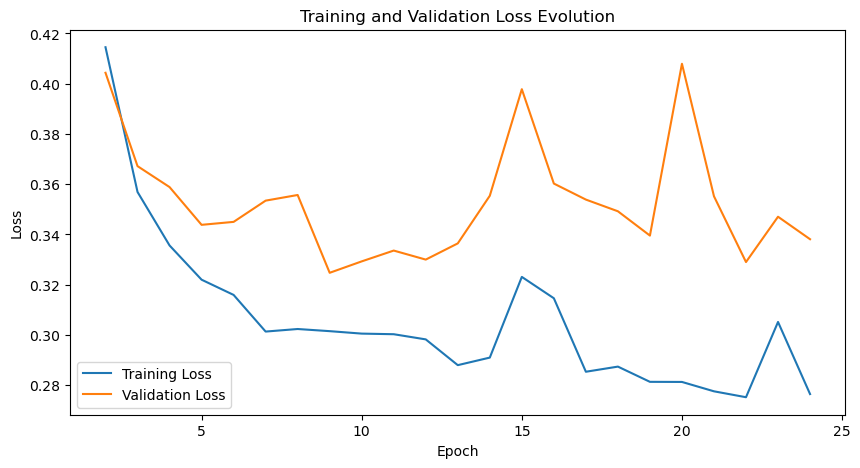

Cross-Entropy on training set:  0.2765
Accuracy on training set:       89.79%

Cross-Entropy on validation set: 0.3381
Accuracy on validation set:      88.18%


In [11]:
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ConvNet, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)

### Exercise 1 (C) ii)

In [12]:
# Use a ResNet-18 without pre-trained weights
ResNet18 = resnet18(weights = None)

# Adapt the ResNet-18 to the FashionMNIST dataset
ResNet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
ResNet18.fc = torch.nn.Linear(ResNet18.fc.in_features, 10)

In [13]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18 = ResNet18.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.3271  |  Accuracy = 80.71% | Batch ID = 469 : 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]


Training Cross-Entropy Loss = 0.5398
Training Accuracy = 80.71%
======== Validation phase ========


Loss = 0.3811  |  Accuracy = 83.92% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 44.92it/s]


Validation Cross-Entropy Loss = 0.4445
Validation Accuracy = 83.92%

Epoch 2/24
======== Training phase ========


Loss = 0.3164  |  Accuracy = 87.21% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Training Cross-Entropy Loss = 0.3516
Training Accuracy = 87.21%
======== Validation phase ========


Loss = 0.2096  |  Accuracy = 87.35% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.57it/s]


Validation Cross-Entropy Loss = 0.3466
Validation Accuracy = 87.35%

Epoch 3/24
======== Training phase ========


Loss = 0.2604  |  Accuracy = 88.62% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]


Training Cross-Entropy Loss = 0.3116
Training Accuracy = 88.62%
======== Validation phase ========


Loss = 0.1827  |  Accuracy = 88.46% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.46it/s]


Validation Cross-Entropy Loss = 0.3092
Validation Accuracy = 88.46%

Epoch 4/24
======== Training phase ========


Loss = 0.2189  |  Accuracy = 89.89% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]


Training Cross-Entropy Loss = 0.2718
Training Accuracy = 89.89%
======== Validation phase ========


Loss = 0.3060  |  Accuracy = 89.29% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.06it/s]


Validation Cross-Entropy Loss = 0.3045
Validation Accuracy = 89.29%

Epoch 5/24
======== Training phase ========


Loss = 0.3646  |  Accuracy = 90.87% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]


Training Cross-Entropy Loss = 0.2486
Training Accuracy = 90.87%
======== Validation phase ========


Loss = 0.5162  |  Accuracy = 89.05% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.69it/s]


Validation Cross-Entropy Loss = 0.3027
Validation Accuracy = 89.05%

Epoch 6/24
======== Training phase ========


Loss = 0.2730  |  Accuracy = 91.22% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Training Cross-Entropy Loss = 0.2324
Training Accuracy = 91.22%
======== Validation phase ========


Loss = 0.3897  |  Accuracy = 89.60% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.86it/s]


Validation Cross-Entropy Loss = 0.2979
Validation Accuracy = 89.60%

Epoch 7/24
======== Training phase ========


Loss = 0.1474  |  Accuracy = 91.20% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


Training Cross-Entropy Loss = 0.2410
Training Accuracy = 91.20%
======== Validation phase ========


Loss = 0.2284  |  Accuracy = 89.33% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.14it/s]


Validation Cross-Entropy Loss = 0.2910
Validation Accuracy = 89.33%

Epoch 8/24
======== Training phase ========


Loss = 0.2158  |  Accuracy = 92.23% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


Training Cross-Entropy Loss = 0.2110
Training Accuracy = 92.23%
======== Validation phase ========


Loss = 0.3940  |  Accuracy = 90.64% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.88it/s]


Validation Cross-Entropy Loss = 0.2688
Validation Accuracy = 90.64%

Epoch 9/24
======== Training phase ========


Loss = 0.1690  |  Accuracy = 92.63% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Training Cross-Entropy Loss = 0.1965
Training Accuracy = 92.63%
======== Validation phase ========


Loss = 0.3342  |  Accuracy = 91.16% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.46it/s]


Validation Cross-Entropy Loss = 0.2547
Validation Accuracy = 91.16%

Epoch 10/24
======== Training phase ========


Loss = 0.1979  |  Accuracy = 93.22% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Training Cross-Entropy Loss = 0.1815
Training Accuracy = 93.22%
======== Validation phase ========


Loss = 0.0920  |  Accuracy = 90.35% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.67it/s]


Validation Cross-Entropy Loss = 0.2724
Validation Accuracy = 90.35%

Epoch 11/24
======== Training phase ========


Loss = 0.1504  |  Accuracy = 93.61% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Training Cross-Entropy Loss = 0.1711
Training Accuracy = 93.61%
======== Validation phase ========


Loss = 0.1575  |  Accuracy = 91.21% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.86it/s]


Validation Cross-Entropy Loss = 0.2572
Validation Accuracy = 91.21%

Epoch 12/24
======== Training phase ========


Loss = 0.1694  |  Accuracy = 93.53% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.85it/s]


Training Cross-Entropy Loss = 0.1765
Training Accuracy = 93.53%
======== Validation phase ========


Loss = 0.6240  |  Accuracy = 90.95% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.64it/s]


Validation Cross-Entropy Loss = 0.2619
Validation Accuracy = 90.95%

Epoch 13/24
======== Training phase ========


Loss = 0.0923  |  Accuracy = 94.27% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Training Cross-Entropy Loss = 0.1516
Training Accuracy = 94.27%
======== Validation phase ========


Loss = 0.2593  |  Accuracy = 91.21% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.28it/s]


Validation Cross-Entropy Loss = 0.2556
Validation Accuracy = 91.21%

Epoch 14/24
======== Training phase ========


Loss = 0.1276  |  Accuracy = 94.58% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]


Training Cross-Entropy Loss = 0.1405
Training Accuracy = 94.58%
======== Validation phase ========


Loss = 0.3526  |  Accuracy = 90.55% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.89it/s]


Validation Cross-Entropy Loss = 0.3018
Validation Accuracy = 90.55%

Epoch 15/24
======== Training phase ========


Loss = 0.0943  |  Accuracy = 95.00% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]


Training Cross-Entropy Loss = 0.1325
Training Accuracy = 95.00%
======== Validation phase ========


Loss = 0.1891  |  Accuracy = 90.77% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.79it/s]


Validation Cross-Entropy Loss = 0.2789
Validation Accuracy = 90.77%

Epoch 16/24
======== Training phase ========


Loss = 0.1103  |  Accuracy = 95.50% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]


Training Cross-Entropy Loss = 0.1204
Training Accuracy = 95.50%
======== Validation phase ========


Loss = 0.2276  |  Accuracy = 90.14% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.56it/s]


Validation Cross-Entropy Loss = 0.2974
Validation Accuracy = 90.14%

Epoch 17/24
======== Training phase ========


Loss = 0.1050  |  Accuracy = 95.72% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]


Training Cross-Entropy Loss = 0.1114
Training Accuracy = 95.72%
======== Validation phase ========


Loss = 0.2877  |  Accuracy = 90.61% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.91it/s]


Validation Cross-Entropy Loss = 0.3027
Validation Accuracy = 90.61%

Epoch 18/24
======== Training phase ========


Loss = 0.0917  |  Accuracy = 96.14% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]


Training Cross-Entropy Loss = 0.1030
Training Accuracy = 96.14%
======== Validation phase ========


Loss = 0.2598  |  Accuracy = 91.26% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.50it/s]


Validation Cross-Entropy Loss = 0.3233
Validation Accuracy = 91.26%

Epoch 19/24
======== Training phase ========


Loss = 0.0816  |  Accuracy = 96.66% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]


Training Cross-Entropy Loss = 0.0891
Training Accuracy = 96.66%
======== Validation phase ========


Loss = 0.4110  |  Accuracy = 90.95% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.02it/s]


Validation Cross-Entropy Loss = 0.3286
Validation Accuracy = 90.95%

Epoch 20/24
======== Training phase ========


Loss = 0.1173  |  Accuracy = 96.73% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]


Training Cross-Entropy Loss = 0.0862
Training Accuracy = 96.73%
======== Validation phase ========


Loss = 0.3015  |  Accuracy = 91.25% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.57it/s]


Validation Cross-Entropy Loss = 0.3047
Validation Accuracy = 91.25%

Epoch 21/24
======== Training phase ========


Loss = 0.0865  |  Accuracy = 97.18% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]


Training Cross-Entropy Loss = 0.0774
Training Accuracy = 97.18%
======== Validation phase ========


Loss = 0.6447  |  Accuracy = 91.24% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.54it/s]


Validation Cross-Entropy Loss = 0.3540
Validation Accuracy = 91.24%

Epoch 22/24
======== Training phase ========


Loss = 0.0699  |  Accuracy = 97.24% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Training Cross-Entropy Loss = 0.0741
Training Accuracy = 97.24%
======== Validation phase ========


Loss = 0.5353  |  Accuracy = 90.91% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.39it/s]


Validation Cross-Entropy Loss = 0.3470
Validation Accuracy = 90.91%

Epoch 23/24
======== Training phase ========


Loss = 0.0470  |  Accuracy = 97.70% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]


Training Cross-Entropy Loss = 0.0623
Training Accuracy = 97.70%
======== Validation phase ========


Loss = 0.9904  |  Accuracy = 91.13% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.94it/s]


Validation Cross-Entropy Loss = 0.3693
Validation Accuracy = 91.13%

Epoch 24/24
======== Training phase ========


Loss = 0.0604  |  Accuracy = 97.67% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Training Cross-Entropy Loss = 0.0648
Training Accuracy = 97.67%
======== Validation phase ========


Loss = 0.2618  |  Accuracy = 91.17% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.00it/s]


Validation Cross-Entropy Loss = 0.3399
Validation Accuracy = 91.17%



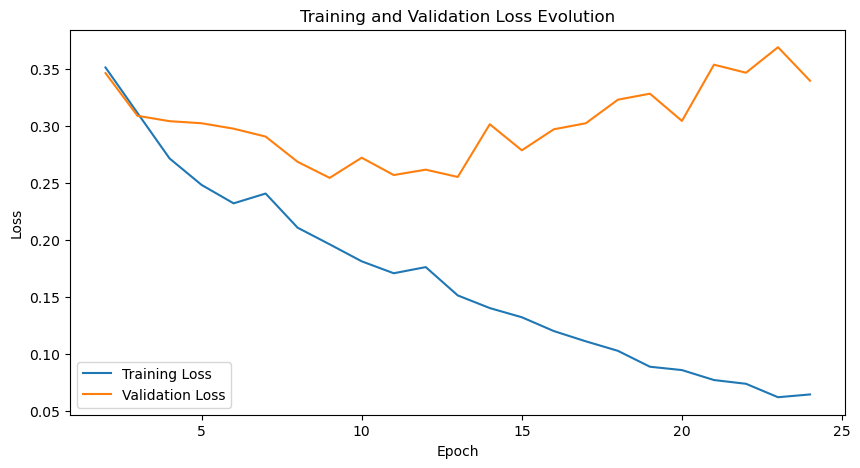

Cross-Entropy on training set:  0.0648
Accuracy on training set:       97.67%

Cross-Entropy on validation set: 0.3399
Accuracy on validation set:      91.17%


In [14]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)

### Exercise 1 (C) iii)

In [15]:
# Use a ResNet-18 with pre-trained weights
ResNet18_pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)

# Adapt the ResNet-18 pre-trained to the FashionMNIST dataset
ResNet18_pretrained.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
ResNet18_pretrained.fc = torch.nn.Linear(ResNet18_pretrained.fc.in_features, 10)

In [16]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18_pretrained = ResNet18_pretrained.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18_pretrained.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.4397  |  Accuracy = 79.22% | Batch ID = 469 : 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Training Cross-Entropy Loss = 0.5770
Training Accuracy = 79.22%
======== Validation phase ========


Loss = 0.3637  |  Accuracy = 83.27% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 52.27it/s]


Validation Cross-Entropy Loss = 0.4610
Validation Accuracy = 83.27%

Epoch 2/24
======== Training phase ========


Loss = 0.3929  |  Accuracy = 86.21% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]


Training Cross-Entropy Loss = 0.3794
Training Accuracy = 86.21%
======== Validation phase ========


Loss = 0.2312  |  Accuracy = 87.96% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.49it/s]


Validation Cross-Entropy Loss = 0.3336
Validation Accuracy = 87.96%

Epoch 3/24
======== Training phase ========


Loss = 0.3710  |  Accuracy = 87.28% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]


Training Cross-Entropy Loss = 0.3454
Training Accuracy = 87.28%
======== Validation phase ========


Loss = 0.1631  |  Accuracy = 87.37% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.72it/s]


Validation Cross-Entropy Loss = 0.3465
Validation Accuracy = 87.37%

Epoch 4/24
======== Training phase ========


Loss = 0.2976  |  Accuracy = 88.93% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]


Training Cross-Entropy Loss = 0.3020
Training Accuracy = 88.93%
======== Validation phase ========


Loss = 0.1677  |  Accuracy = 88.68% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.20it/s]


Validation Cross-Entropy Loss = 0.2997
Validation Accuracy = 88.68%

Epoch 5/24
======== Training phase ========


Loss = 0.3582  |  Accuracy = 90.08% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]


Training Cross-Entropy Loss = 0.2678
Training Accuracy = 90.08%
======== Validation phase ========


Loss = 0.1839  |  Accuracy = 89.01% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.77it/s]


Validation Cross-Entropy Loss = 0.2974
Validation Accuracy = 89.01%

Epoch 6/24
======== Training phase ========


Loss = 0.1856  |  Accuracy = 90.79% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


Training Cross-Entropy Loss = 0.2476
Training Accuracy = 90.79%
======== Validation phase ========


Loss = 0.1343  |  Accuracy = 89.37% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.40it/s]


Validation Cross-Entropy Loss = 0.2900
Validation Accuracy = 89.37%

Epoch 7/24
======== Training phase ========


Loss = 0.3005  |  Accuracy = 91.47% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]


Training Cross-Entropy Loss = 0.2322
Training Accuracy = 91.47%
======== Validation phase ========


Loss = 0.0780  |  Accuracy = 90.39% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.37it/s]


Validation Cross-Entropy Loss = 0.2598
Validation Accuracy = 90.39%

Epoch 8/24
======== Training phase ========


Loss = 0.1608  |  Accuracy = 91.76% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Training Cross-Entropy Loss = 0.2198
Training Accuracy = 91.76%
======== Validation phase ========


Loss = 0.0519  |  Accuracy = 90.59% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.48it/s]


Validation Cross-Entropy Loss = 0.2588
Validation Accuracy = 90.59%

Epoch 9/24
======== Training phase ========


Loss = 0.2982  |  Accuracy = 92.13% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Training Cross-Entropy Loss = 0.2099
Training Accuracy = 92.13%
======== Validation phase ========


Loss = 0.0815  |  Accuracy = 90.45% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.88it/s]


Validation Cross-Entropy Loss = 0.2627
Validation Accuracy = 90.45%

Epoch 10/24
======== Training phase ========


Loss = 0.1474  |  Accuracy = 92.55% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]


Training Cross-Entropy Loss = 0.2014
Training Accuracy = 92.55%
======== Validation phase ========


Loss = 0.0987  |  Accuracy = 90.00% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.00it/s]


Validation Cross-Entropy Loss = 0.2837
Validation Accuracy = 90.00%

Epoch 11/24
======== Training phase ========


Loss = 0.1966  |  Accuracy = 92.87% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]


Training Cross-Entropy Loss = 0.1897
Training Accuracy = 92.87%
======== Validation phase ========


Loss = 0.0999  |  Accuracy = 91.22% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.20it/s]


Validation Cross-Entropy Loss = 0.2538
Validation Accuracy = 91.22%

Epoch 12/24
======== Training phase ========


Loss = 0.4493  |  Accuracy = 91.86% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]


Training Cross-Entropy Loss = 0.2361
Training Accuracy = 91.86%
======== Validation phase ========


Loss = 0.9683  |  Accuracy = 73.31% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.23it/s] 


Validation Cross-Entropy Loss = 1.9495
Validation Accuracy = 73.31%

Epoch 13/24
======== Training phase ========


Loss = 0.2399  |  Accuracy = 88.68% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


Training Cross-Entropy Loss = 0.2993
Training Accuracy = 88.68%
======== Validation phase ========


Loss = 0.3784  |  Accuracy = 88.52% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.69it/s]


Validation Cross-Entropy Loss = 0.3080
Validation Accuracy = 88.52%

Epoch 14/24
======== Training phase ========


Loss = 0.2596  |  Accuracy = 91.63% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]


Training Cross-Entropy Loss = 0.2252
Training Accuracy = 91.63%
======== Validation phase ========


Loss = 0.5796  |  Accuracy = 89.61% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.54it/s]


Validation Cross-Entropy Loss = 0.2926
Validation Accuracy = 89.61%

Epoch 15/24
======== Training phase ========


Loss = 0.1460  |  Accuracy = 92.71% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Training Cross-Entropy Loss = 0.1979
Training Accuracy = 92.71%
======== Validation phase ========


Loss = 0.1174  |  Accuracy = 90.86% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.16it/s]


Validation Cross-Entropy Loss = 0.2639
Validation Accuracy = 90.86%

Epoch 16/24
======== Training phase ========


Loss = 0.1051  |  Accuracy = 93.23% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


Training Cross-Entropy Loss = 0.1823
Training Accuracy = 93.23%
======== Validation phase ========


Loss = 0.2648  |  Accuracy = 91.15% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.17it/s]


Validation Cross-Entropy Loss = 0.2631
Validation Accuracy = 91.15%

Epoch 17/24
======== Training phase ========


Loss = 0.2063  |  Accuracy = 93.73% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]


Training Cross-Entropy Loss = 0.1675
Training Accuracy = 93.73%
======== Validation phase ========


Loss = 0.2486  |  Accuracy = 90.93% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.83it/s]


Validation Cross-Entropy Loss = 0.2571
Validation Accuracy = 90.93%

Epoch 18/24
======== Training phase ========


Loss = 0.1747  |  Accuracy = 94.19% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]


Training Cross-Entropy Loss = 0.1569
Training Accuracy = 94.19%
======== Validation phase ========


Loss = 0.3013  |  Accuracy = 91.15% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.19it/s]


Validation Cross-Entropy Loss = 0.2757
Validation Accuracy = 91.15%

Epoch 19/24
======== Training phase ========


Loss = 0.1625  |  Accuracy = 91.93% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


Training Cross-Entropy Loss = 0.2181
Training Accuracy = 91.93%
======== Validation phase ========


Loss = 0.4670  |  Accuracy = 90.71% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.87it/s]


Validation Cross-Entropy Loss = 0.2707
Validation Accuracy = 90.71%

Epoch 20/24
======== Training phase ========


Loss = 0.3068  |  Accuracy = 93.81% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]


Training Cross-Entropy Loss = 0.1653
Training Accuracy = 93.81%
======== Validation phase ========


Loss = 0.2498  |  Accuracy = 91.22% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.54it/s]


Validation Cross-Entropy Loss = 0.2473
Validation Accuracy = 91.22%

Epoch 21/24
======== Training phase ========


Loss = 0.1765  |  Accuracy = 94.52% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Training Cross-Entropy Loss = 0.1447
Training Accuracy = 94.52%
======== Validation phase ========


Loss = 0.3622  |  Accuracy = 91.10% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.67it/s]


Validation Cross-Entropy Loss = 0.2725
Validation Accuracy = 91.10%

Epoch 22/24
======== Training phase ========


Loss = 0.1207  |  Accuracy = 94.95% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]


Training Cross-Entropy Loss = 0.1327
Training Accuracy = 94.95%
======== Validation phase ========


Loss = 0.1766  |  Accuracy = 91.00% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 51.24it/s]


Validation Cross-Entropy Loss = 0.2800
Validation Accuracy = 91.00%

Epoch 23/24
======== Training phase ========


Loss = 0.0517  |  Accuracy = 95.29% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Training Cross-Entropy Loss = 0.1240
Training Accuracy = 95.29%
======== Validation phase ========


Loss = 0.2391  |  Accuracy = 91.50% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.87it/s]


Validation Cross-Entropy Loss = 0.2678
Validation Accuracy = 91.50%

Epoch 24/24
======== Training phase ========


Loss = 0.1870  |  Accuracy = 95.63% | Batch ID = 469 : 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Training Cross-Entropy Loss = 0.1134
Training Accuracy = 95.63%
======== Validation phase ========


Loss = 0.2033  |  Accuracy = 91.37% | Batch ID = 79 : 100%|██████████| 79/79 [00:01<00:00, 50.95it/s]


Validation Cross-Entropy Loss = 0.2943
Validation Accuracy = 91.37%



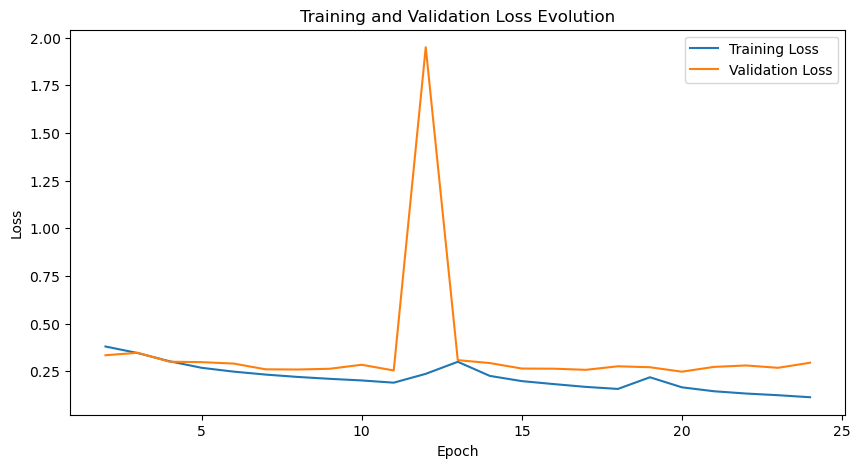

Cross-Entropy on training set:  0.1134
Accuracy on training set:       95.63%

Cross-Entropy on validation set: 0.2943
Accuracy on validation set:      91.37%


In [17]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18_pretrained, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)